# Import

In [1]:
# add path to the current directory
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.getcwd())

# switch to the simulation directory
# Verify the current directory
print("Current directory:", os.getcwd())

%load_ext autoreload
%autoreload 2

import sys
# assert('neuron' not in sys.modules)
import os
nrn_options = "-nogui -NSTACK 100000 -NFRAME 20000"
os.environ["NEURON_MODULE_OPTIONS"] = nrn_options
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
import time
import math

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from functools import partial
from skopt.plots import plot_convergence
from skopt import gp_minimize
from skopt.space import Real
import torch


from brian2 import *
from utils.brian2_utils import set_params_utils, eqs_utils, plotting_utils, obj_func_utils
from utils.botorch_utils import ibnn_utils

Current directory: /Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO       Cache size for target 'cython': 1288 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/Users/dusiyi/Library/Caches/cython/brian_extensions' directory. [brian2]
WARNING    /opt/miniconda3/envs/brian2_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 [py.warnings]


# Set up model

## params

In [2]:
# populations
N = 700
N_E = int(N * 0.8)  # pyramidal neurons
N_I = int(N * 0.2)  # interneurons
f = 0.1
p = 3
C_ext = 800
DC_amp = 0

# external stimuli
# rate = 3 * Hz # in external noise
currents_to_track = ['I_syn', 'I_AMPA_ext', 'I_GABA_rec', 'I_AMPA_rec', 'I_NMDA_rec', 'I_DC1', 'I_DC2', 'I_sino1', 'I_sino2']
currents_to_plot = currents_to_track

## currents

In [3]:
DC_input_ts = 1 * ms
sino_input_ts = 0.1 * ms

# currently set the duration of all currents to 0, so that they are not applied

DC_start_time1 = 0  # in ms
# DC_duration1 = 1000  # in ms
DC_duration1 = 0  # in ms
DC_amp1 = 0.1  # in nA
DC_amp_slope1 = 0.001  # in nA/ms

DC_start_time2 = 500  # in ms
# DC_duration2 = 2000  # in ms
DC_duration2 = 0  # in ms
DC_amp2 = -0.05  # in nA
DC_amp_slope2 = -0.001  # in nA/ms

sino_start_time1 = 0  # in ms
# sino_duration1=3000  # in ms
sino_duration1=0  # in ms
sino_amp1=0.5  # in nA
sino_freq1=30  # in Hz

sino_start_time2 = 1000  # in ms
# sino_duration2=2000  # in ms
sino_duration2=0  # in ms
sino_amp2=0.2  # in nA
sino_freq2=50  # in Hz



DC_input1 = set_params_utils.set_DC_input(DC_amp=DC_amp1, # in nA
                DC_amp_slope=DC_amp_slope1, # in nA/ms
                DC_duration=DC_duration1, # in ms
                DC_start_time=DC_start_time1, # in ms
                timestep=DC_input_ts
                )

DC_input2 = set_params_utils.set_DC_input(DC_amp=DC_amp2, # in nA
                DC_amp_slope=DC_amp_slope2, # in nA/ms
                DC_duration=DC_duration2, # in ms
                DC_start_time=DC_start_time2, # in ms
                timestep=DC_input_ts
                )

sino_input1 = set_params_utils.set_sino_input(sino_start_time=sino_start_time1, # in ms
                    sino_duration=sino_duration1, # in ms
                    sino_amp=sino_amp1, # in nA
                    sino_freq=sino_freq1, # in Hz
                    timestep=sino_input_ts
                    )

sino_input2 = set_params_utils.set_sino_input(sino_start_time=sino_start_time2, # in ms
                    sino_duration=sino_duration2, # in ms
                    sino_amp=sino_amp2, # in nA
                    sino_freq=sino_freq2, # in Hz
                    timestep=sino_input_ts
                    )

## run initial simulation

Starting simulation at t=0. s for a duration of 5. s
2.5881 s (51%) simulated in 10s, estimated 9s remaining.
5. s (100%) simulated in 19s


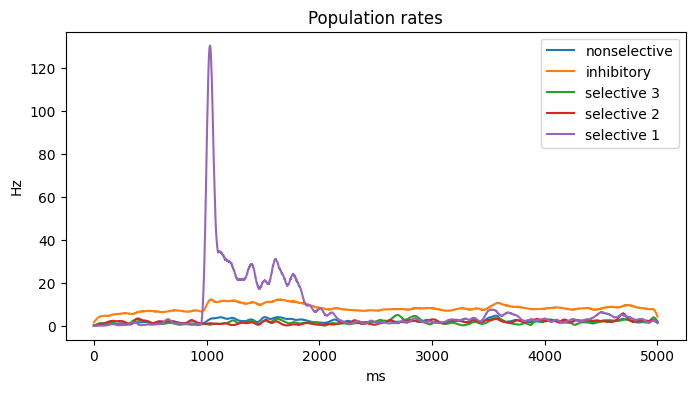

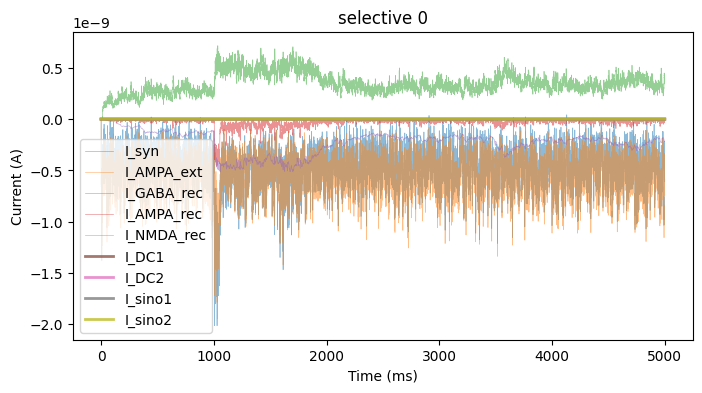

In [4]:
start_scope()

N_sub = int(N_E * f)
N_non = int(N_E * (1. - f * p))


E_neuron_index = [0] # index of the neuron in the population
E_index_map = {0: 'nonselective'} # map the index in the monitor to population name
for i in range(p):
    E_neuron_index.append(N_non + i * N_sub)
    E_index_map[i+1] = f'selective {i}'


# voltage
V_L, V_thr, V_reset, V_E, V_I = set_params_utils.set_voltage()
# membrane capacitance and membrane leak
C_m_E, C_m_I, g_m_E, g_m_I = set_params_utils.set_membrane_params()

# AMPA (excitatory)
g_AMPA_ext_E, g_AMPA_rec_E, g_AMPA_ext_I, g_AMPA_rec_I, tau_AMPA = set_params_utils.set_AMPA_params(N_E)
# NMDA (excitatory)
g_NMDA_E, g_NMDA_I, tau_NMDA_rise, tau_NMDA_decay, alpha, Mg2 = set_params_utils.set_NMDA_params(N_E)
# GABAergic (inhibitory)
g_GABA_E, g_GABA_I, tau_GABA = set_params_utils.set_GABA_params(N_I)

# Write the equations for the target population (e.g., excitatory population P_E)
eqs_E = eqs_utils.write_eqs_E()
eqs_I = eqs_utils.write_eqs_I()
eqs_glut, eqs_pre_glut, eqs_pre_gaba = eqs_utils.write_other_eqs()

# neuron groups 
P_E, P_I = set_params_utils.set_neuron_groups(N_E, N_I, eqs_E, eqs_I, V_L)
# synapses
external_noise_rate = 3 * Hz
C_E, C_I, C_E_E, C_E_I, C_I_I, C_I_E, C_P_E, C_P_I = set_params_utils.set_synapses(P_E, P_I, N_E, N_I, N_sub, N_non, p, f, C_ext, external_noise_rate, eqs_glut, eqs_pre_glut, eqs_pre_gaba)


N_activity_plot = 15
DC_monitor_E, r_E_sels, r_E, r_I = set_params_utils.set_monitors_for_optimization_algorithm(N_activity_plot, N_non, N_sub, p, P_E, P_I, E_neuron_index=E_neuron_index, currents_to_track=currents_to_track)

## set external stimuli
# at 1s, select population 1
C_selection = int(f * C_ext)
rate_selection = 25 * Hz


stimuli1 = TimedArray(np.r_[np.zeros(40), np.ones(2), np.zeros(100)], dt=25 * ms)
input1 = PoissonInput(P_E[N_non:N_non + N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli1(t)')

# # at 2s, select population 2
# stimuli2 = TimedArray(np.r_[np.zeros(80), np.ones(2), np.zeros(100)], dt=25 * ms)
# input2 = PoissonInput(P_E[N_non + N_sub:N_non + 2 * N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli2(t)')


# simulate, can be long >120s
net = Network(collect())
net.add(r_E_sels)
net.add(P_E, P_I, C_E_E, C_E_I, C_I_I, C_I_E, C_P_E, C_P_I)


net.store('initial')

net.run(5 * second, report='stdout')

plotting_utils.plot_firing_rate(r_E, r_I, r_E_sels)
plotting_utils.plot_currents(DC_monitor_E, None, currents_to_plot, E_index_map)

## set obj func

In [5]:
DC_amp1_range = [-0.3, 0]
DC_amp_slope1_range = [-0.2, 0.2]
DC_start_time1_range = [0, 3000]
DC_duration1_range = [20, 4000]

DC_amp2_range = [0, 0.3]
DC_amp_slope2_range = [-0.2, 0.2]
DC_start_time2_range = [0, 3000]
DC_duration2_range = [20, 4000]

sino_start_time1_range = [0, 3000]
sino_duration1_range = [20, 4000]
sino_amp1_range = [0, 0.3]
sino_freq1_range = [0.01, 10]

sino_start_time2_range = [0, 3000]
sino_duration2_range = [20, 4000]
sino_amp2_range = [0, 0.3]
sino_freq2_range = [0.01, 10]


space = [
            Real(DC_start_time1_range[0], DC_start_time1_range[1], name='DC_start_time1'),
            Real(DC_duration1_range[0], DC_duration1_range[1], name='DC_duration1'),
            Real(DC_amp1_range[0], DC_amp1_range[1], name='DC_amp1'),
            Real(DC_amp_slope1_range[0], DC_amp_slope1_range[1], name='DC_amp_slope1'),
            Real(DC_start_time2_range[0], DC_start_time2_range[1], name='DC_start_time2'),
            Real(DC_duration2_range[0], DC_duration2_range[1], name='DC_duration2'),
            Real(DC_amp2_range[0], DC_amp2_range[1], name='DC_amp2'),
            Real(DC_amp_slope2_range[0], DC_amp_slope2_range[1], name='DC_amp_slope2'),
            Real(sino_start_time1_range[0], sino_start_time1_range[1], name='sino_start_time1'),
            Real(sino_duration1_range[0], sino_duration1_range[1], name='sino_duration1'),
            Real(sino_amp1_range[0], sino_amp1_range[1], name='sino_amp1'),
            Real(sino_freq1_range[0], sino_freq1_range[1], name='sino_freq1'),
            Real(sino_start_time2_range[0], sino_start_time2_range[1], name='sino_start_time2'),
            Real(sino_duration2_range[0], sino_duration2_range[1], name='sino_duration2'),
            Real(sino_amp2_range[0], sino_amp2_range[1], name='sino_amp2'),
            Real(sino_freq2_range[0], sino_freq2_range[1], name='sino_freq2')]


namespace = {'V_L': V_L, 'V_thr': V_thr, 'V_reset': V_reset, 'V_E': V_E, 'V_I': V_I,
            'C_m_E': C_m_E, 'C_m_I': C_m_I, 'g_m_E': g_m_E, 'g_m_I': g_m_I,
            'g_AMPA_ext_E': g_AMPA_ext_E, 'g_AMPA_rec_E': g_AMPA_rec_E, 'g_AMPA_ext_I': g_AMPA_ext_I,
            'g_AMPA_rec_I': g_AMPA_rec_I, 'tau_AMPA': tau_AMPA,
            'g_NMDA_E': g_NMDA_E, 'g_NMDA_I': g_NMDA_I,
            'tau_NMDA_rise': tau_NMDA_rise, 'tau_NMDA_decay': tau_NMDA_decay,
            'alpha': alpha, 'Mg2': Mg2,
            'g_GABA_E': g_GABA_E, 'g_GABA_I': g_GABA_I, 'tau_GABA': tau_GABA,
            'stimuli1': stimuli1, 
            #'stimuli2': stimuli2,
            }

objective_with_factor = partial(obj_func_utils.objective_function, net=net, namespace=namespace, DC_monitor_E=DC_monitor_E, r_E=r_E, r_I=r_I, r_E_sels=r_E_sels,
                                 E_index_map=E_index_map, maximize=False,)

In [6]:
pls_stop 
# go to BP-IBNN

NameError: name 'pls_stop' is not defined

# SAC

In [ ]:
import gymnasium as gym

from stable_baselines3 import SAC

env = gym.make("Pendulum-v1", render_mode="human")

model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)
model.save("sac_pendulum")

del model # remove to demonstrate saving and loading

model = SAC.load("sac_pendulum")

obs, info = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

# Multiff example

# Env

## regular

In [ ]:
env_kwargs = {}
env = env_for_sb3.EnvForSB3(**env_kwargs)
model_folder_name = "RL_models/SB3_stored_models/all_agents/regular"
env = Monitor(env, model_folder_name)

# Agent

## make agent

In [ ]:
# For direct training
sac_model = SAC("MlpPolicy", 
            env,
            gamma=0.995,
            learning_rate=0.0015,
            batch_size=1024,
            target_update_interval=50,
            buffer_size=1000000,
            learning_starts=10000,
            train_freq=10,
            ent_coef='auto',
            policy_kwargs=dict(activation_fn=nn.Tanh, net_arch=[128, 128])
            )

## load agent (optional)

In [ ]:
path = os.path.join(model_folder_name, 'best_model.zip')
path2 = os.path.join(model_folder_name, 'buffer.pkl')
sac_model = sac_model.load(path,env=env) 
sac_model.load_replay_buffer(path2)

## Train agent

In [ ]:
callback = SB3_functions.SaveOnBestTrainingRewardCallback(check_freq=20000, model_folder_name=model_folder_name)
#timesteps = 50000000
timesteps = 5000000
sac_model.learn(total_timesteps=int(timesteps), callback=callback)
plot_results([model_folder_name], timesteps, results_plotter.X_TIMESTEPS, "env.MultiFF")
plt.show()

In [ ]:
plot_results([model_folder_name], timesteps, results_plotter.X_TIMESTEPS, "env.MultiFF")
plt.show()

In [ ]:
sac_model.save(os.path.join(model_folder_name, 'best_model'))
sac_model.save_replay_buffer(os.path.join(model_folder_name, 'buffer')) # I added this

In [ ]:
stop_train_callback = SB3_functions.StopTrainingOnNoModelImprovement(max_no_improvement_evals=10, min_evals=20, verbose=1)
callback = EvalCallback(env, eval_freq=5000, callback_after_eval=stop_train_callback, verbose=1)
# timesteps = 50000000
timesteps = 5000000
sac_model.learn(total_timesteps=int(timesteps), callback=callback)

sac_model.save(os.path.join(model_folder_name, 'best_model'))
sac_model.save_replay_buffer(os.path.join(model_folder_name, 'buffer')) # I added this

# Test agent

In [ ]:
obs, _ = env.reset()
cum_rewards = 0
for step in range(1000):
    action, _ = sac_model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    cum_rewards += reward
    if done:
        obs, _ = env.reset()
    # print(step, ffxy_visible[-1])
print(cum_rewards)